In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip' &> /dev/null

In [ ]:
from PIL import Image as I
from PIL import ImageFilter
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import train_test_split as split
from scipy.stats import mode
from sklearn.metrics import confusion_matrix as cm
import cv2
import random
from distutils.file_util import copy_file
np.set_printoptions(suppress=True)

In [ ]:
non = '/content/Data/Non Demented'
vmild = '/content/Data/Very mild Dementia'
mild = '/content/Data/Mild Dementia'
mod = '/content/Data/Moderate Dementia'

In [ ]:
listmod = []
listnon = []
listvmild = []
listmild = []

for root, directories, files in os.walk(mod):
    for name in files:
        listmod.append(os.path.join(root, name))
for root, directories, files in os.walk(non):
    for name in files:
        listnon.append(os.path.join(root, name))
for root, directories, files in os.walk(vmild):
    for name in files:
        listvmild.append(os.path.join(root, name))
for root, directories, files in os.walk(mild):
    for name in files:
        listmild.append(os.path.join(root, name))



seed_value = 0
random.seed(seed_value)
random.shuffle(listmod)
random.shuffle(listnon)
random.shuffle(listvmild)
random.shuffle(listmild)

!mkdir ./Newdata
!mkdir ./Newdata/mild
!mkdir ./Newdata/non
!mkdir ./Newdata/vmild
!mkdir ./Newdata/mod

In [ ]:
pvmild = '/content/Newdata/vmild'
pnon = '/content/Newdata/non'
pmild = '/content/Newdata/mild'
pmod = '/content/Newdata/mod'

for i in range(488):
    copy_file(listvmild[i], pvmild)
    copy_file(listmild[i], pmild)
    copy_file(listnon[i], pnon)
    copy_file(listmod[i], pmod)

In [ ]:
dir = [pnon, pvmild, pmild, pmod]
main_image_list = []
labels = []

for i in range(4):
    location = sorted( os.listdir( dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( dir[i] , file_name )
        image = I.open(file_path)
        #image = image.filter(ImageFilter.GaussianBlur(radius=2))
        new_image = image.convert('L').resize(( 128,64)) #resizing image to 1/4 size
        image2D = np.array(new_image) #reading 2D matrix
        image2D = cv2.Canny(image2D, 50, 150)
        image1D = image2D.flatten() #flattening to 1D matrix
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list) #concatinating list vertically to get 154x1600 shape
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    main_image_list.append(concatenated_images)
    labels.append(concatenated_labels)

(488, 8192)
(488, 8192)
(488, 8192)
(488, 8192)


In [ ]:
main_image_list = np.vstack(main_image_list)
main_image_list.shape

(1952, 8192)

In [ ]:
labels = np.vstack(labels)
labels.shape

(1952, 1)

In [ ]:
data = np.concatenate((labels, main_image_list), axis=1)
df = pd.DataFrame(data)


In [ ]:
random_seed = 0
S_df = df.sample(frac=1, random_state = random_seed)

In [ ]:
train_df, test_df = split(S_df, test_size= 1/3, random_state=0)

In [ ]:
n_df = train_df.iloc[:,:1]

In [ ]:
p_df = train_df.iloc[:,1:]

In [ ]:
n_df_t = test_df.iloc[:,:1]

In [ ]:
p_df_t = test_df.iloc[:,1:]

### Training

In [ ]:
X_train = p_df.values
Y_train = n_df.values
X_test = p_df_t.values
Y_test = n_df_t.values

In [ ]:
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [ ]:
K = 5
s = X_test.shape[0]
t = X_train.shape[0]
p = np.zeros(s)
for i in range(s):
    similar = np.zeros(t)
    for j in range(t):
        t_min = np.minimum(X_test[i, :], X_train[j, :])
        sim = np.sum(t_min)
        similar[j] = sim
    sorted_index = np.argsort(similar)[::-1]
    knn_index = sorted_index[:K]
    knn_label = Y_train[knn_index]
    p[i] = np.bincount(knn_label).argmax()

In [ ]:
np.mean(p==Y_test)

0.7803379416282642

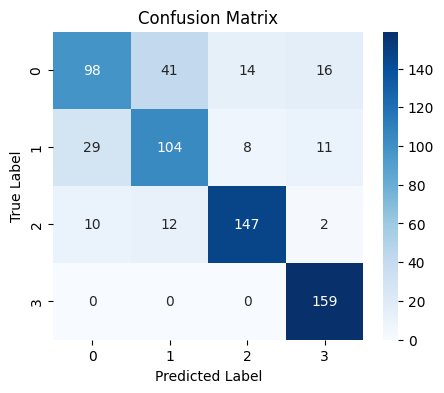

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = cm(Y_test, p)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
def fit(X, y):
    n, m = X.shape
    cls = np.unique(y)
    tot_cls = len(cls)
    pred = {}
    feature = {}
    for i in cls:
        class_count = np.count_nonzero(y == i)
        pred[i] = np.log(class_count / n)
        j = (y == i)
        t = X[j]
        feature[i] = {}
        for k in range(m):
            feature[i][k] = X[j, k]
    return pred, feature

In [ ]:
def predict(x, pred, feature):
    n_val, m_val = x.shape
    kys = list(pred.keys())
    num = len(kys)
    postr = np.zeros((n_val, num))
    for i in range(num):
        for j in range(n_val):
            postr[j, i] = pred[kys[i]]
            for k in range(m_val):
                postr[j, i] += np.log(np.sum(feature[kys[i]][k] == x[j, k]) / (len(feature[kys[i]][k]))+1e-10)
    cfs = np.argmax(postr, axis=1)
    return cfs

In [ ]:
pred, feature = fit(X_train, Y_train)
preds = predict(X_test, pred, feature)
np.mean(preds== Y_test)

0.5960061443932412

In [ ]:
# import shutil

In [ ]:
# !mkdir ./128_NB
# np.save('/content/128_NB/128_NB_weights.npy', feature)
# np.save('/content/128_NB/128_NB_prior.npy', pred)

# New = '/content/128_NB'
# zip_filename = '/content/128_NB'
# shutil.make_archive(zip_filename, 'zip', New)
# !cp 128_NB.zip '/content/drive/MyDrive'

mkdir: cannot create directory ‘./128_NB’: File exists


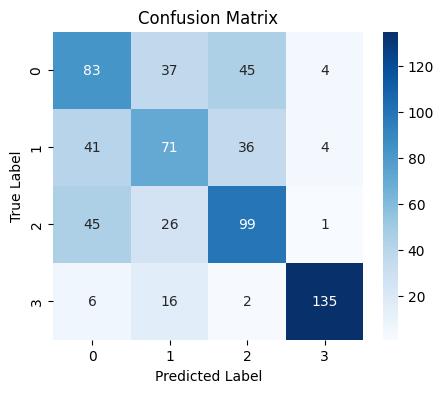

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = cm(Y_test, preds)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()